In [133]:
import numpy
numpy.seterr(divide='warn')
import pandas
from tkinter import Tk
from tkinter.filedialog import askdirectory
import seaborn
import matplotlib.pyplot as plt
import math

In [134]:
experimentPath = "/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/20221202_Initial_Full_Data_Run"#askdirectory(title='Select Folder Containing the experiment data')
print(experimentPath)
IMUData = pandas.read_csv("{}/20221203_IMUAngleData.csv".format(experimentPath))
MCData = pandas.read_csv("{}/20221203_MotionCaptureAngleData.csv".format(experimentPath))
LogData = pandas.read_csv("{}/20221202_FullDataArmLog.txt".format(experimentPath), delimiter=';')
videoFramerate = 60
MCData['Time'] = MCData['Frame'].values/videoFramerate
MCData['Normed Angle'] = MCData['Angle'].values[0] - MCData['Angle'].values
LogData['Logs'] = LogData['Speeds before shuffling']
logSpeedsStart = int(numpy.where(LogData['Logs'] == "Speeds after shuffling")[0]) + 1
logSpeedsEnd = int(numpy.where(LogData['Logs'] == "Press both limit switches to begin calibration")[0])
logSpeeds = LogData['Logs'].values[logSpeedsStart : logSpeedsEnd]

/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/20221202_Initial_Full_Data_Run


<AxesSubplot: >

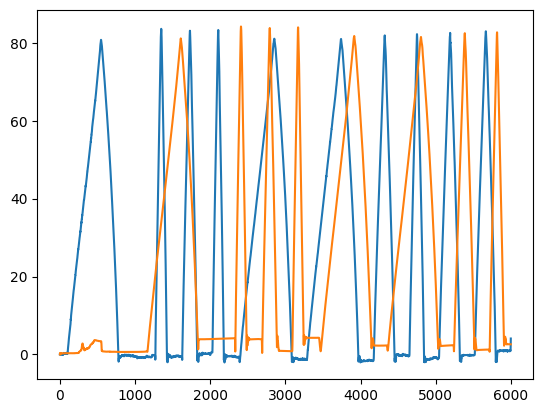

In [135]:

trimLength = 6000
MCtimeVec = numpy.arange(0, max(MCData['Time']), IMUData['Time'].values[1])
MCAngle = numpy.interp(MCtimeVec, MCData['Time'].values, MCData['Normed Angle'].values)[:trimLength]
MCtimeVec = MCtimeVec[:trimLength]
IMUtimeVec = numpy.arange(0, max(IMUData['Time']), IMUData['Time'].values[1])
IMUAngle = numpy.interp(IMUtimeVec, IMUData['Time'].values, IMUData['IMU Arm Angle'].values)[:trimLength]
IMUtimeVec = IMUtimeVec[:trimLength]
seaborn.lineplot(MCAngle)
seaborn.lineplot(IMUAngle)

-1063


<AxesSubplot: >

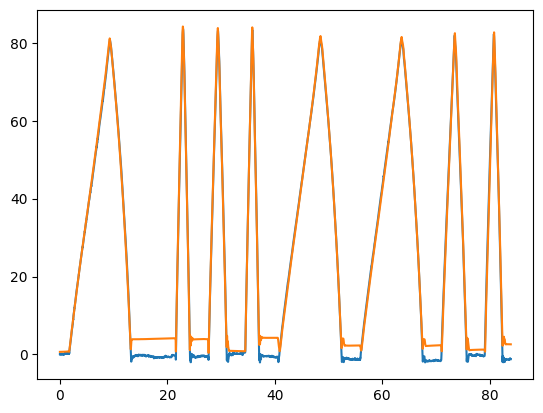

In [136]:
corr = numpy.correlate(MCAngle, IMUAngle, mode='full')
lag = corr.argmax() - (len(MCAngle) - 1)
print(lag)
if lag > 0:
    MCAngle = MCAngle[lag:]
    MCtimeVec = MCtimeVec[lag:]
    IMUAngle = IMUAngle[:-lag]
    IMUtimeVec = IMUtimeVec[:-lag]
    sharedTimeVec = IMUtimeVec
elif lag < 0:
    lag = numpy.abs(lag)
    MCAngle = MCAngle[:-lag]
    MCtimeVec = MCtimeVec[:-lag]
    IMUAngle = IMUAngle[lag:]
    IMUtimeVec = IMUtimeVec[lag:]
    sharedTimeVec = MCtimeVec

# seaborn.lineplot(corr)
seaborn.lineplot(y=MCAngle, x = sharedTimeVec)
seaborn.lineplot(y=IMUAngle, x = sharedTimeVec)
    

- Statistical Analysis
- ANOVA of:
    - Speed groups + steady - difference
- Regression:
    - Difference against mean
    - Difference against angular velocity
- Power Analysis:
    - "the root-meansquare errors achieved by the best IOE algorithms are in the range of 1° to 3° for slow and smooth motions and as much as 5° to 15° for fast and challenging motions [12, 19]. Further improving this accuracy seems highly desirable in view of numerous applications." Laidig
    - Comparison of RMS error accross whole movement.
    - alpha 95 beta 80, detect a different of 3 degrees
    - RMS error for each move
    - Standard deviation of each move RMS

- Video Report
- Video of the experiment
- Rubric:
    - Overview
    - Procedure
    - Results
    - Discussion

    OR?

    - Executive Summary
    - Significance
    - Results/Discussion
    - Conclusions

https://cloudfront.jove.com/files/media/AuthorProducedCriteria.pdf

In [137]:
MCVel = numpy.diff(MCAngle)/numpy.mean(numpy.diff(sharedTimeVec))
IMUVel = numpy.diff(IMUAngle)/numpy.mean(numpy.diff(sharedTimeVec))

<AxesSubplot: >

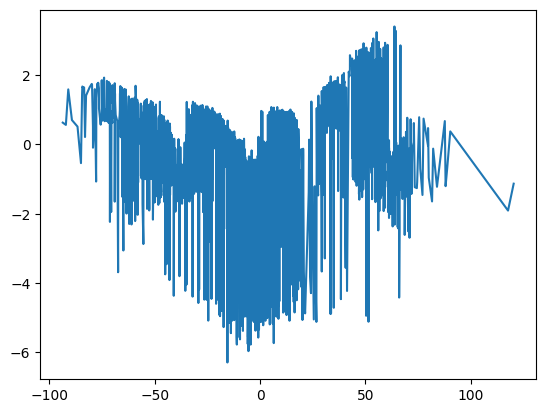

In [138]:
dataSum = IMUAngle + MCAngle
mean = dataSum/2
difference = MCAngle - IMUAngle
# seaborn.lineplot(y=difference, x=mean)
seaborn.lineplot(y=difference[:-1], x=(MCVel + IMUVel)/2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encount

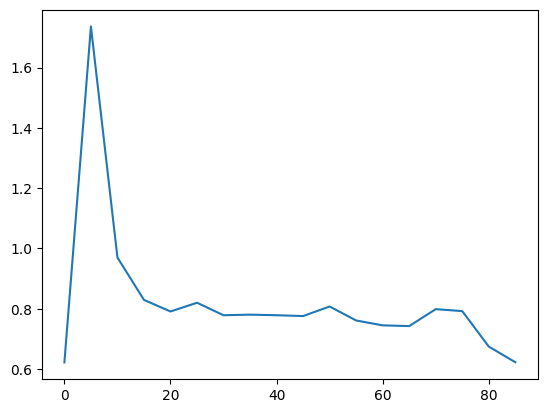

In [144]:
bins = [-5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110]
indices = numpy.digitize(mean, bins)
binnedDifference = []
binnedMeanDiff = []
binnedStdDiff = []
numInBin = []
for i in range(len(bins)):
    locs = numpy.where(indices == i)
    diff = difference[locs]
    binnedDifference.append(diff)
    binnedMeanDiff.append(numpy.mean(diff))
    binnedStdDiff.append(numpy.std(diff))
    numInBin.append(len(diff))

seaborn.lineplot(y=binnedStdDiff, x=bins)
maxSTD = max(binnedStdDiff)

<AxesSubplot: >

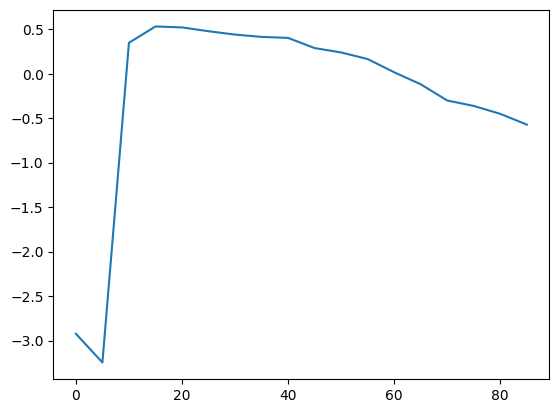

In [140]:
seaborn.lineplot(y=binnedMeanDiff, x=bins)

<AxesSubplot: >

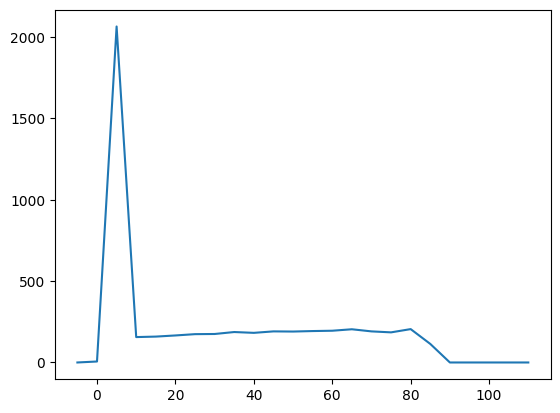

In [141]:
seaborn.lineplot(y=numInBin, x=bins)

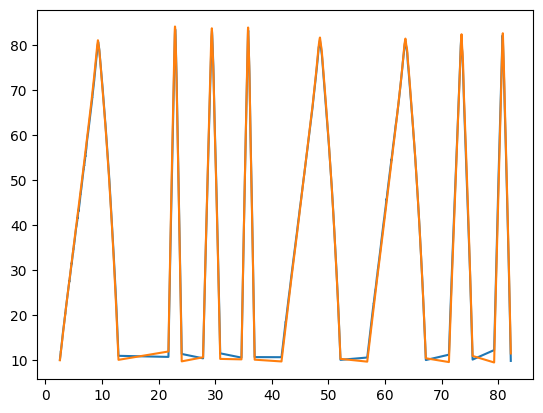

In [142]:
indexThreshold = 3
seaborn.lineplot(y=MCAngle[numpy.where(indices>indexThreshold)], x=sharedTimeVec[numpy.where(indices>indexThreshold)])
seaborn.lineplot(y=IMUAngle[numpy.where(indices>indexThreshold)], x=sharedTimeVec[numpy.where(indices>indexThreshold)])
timeDuringMove = sharedTimeVec[numpy.where(indices>indexThreshold)]
timeDiff = numpy.diff(timeDuringMove)
nonMoving = numpy.where(timeDiff > 1)[0]
cycles = {}
slowMoves = numpy.array(numpy.empty((2, 1)))
medSlowMoves = numpy.array(numpy.empty((2, 1)))
medFastMoves = numpy.array(numpy.empty((2, 1)))
fastMoves = numpy.array(numpy.empty((2, 1)))
for i in range(len(logSpeeds)):
    if i == 0:
        cycle = pandas.DataFrame()
        cycle['Calibration MC'] = MCAngle[0:int(nonMoving[i])]
        cycle["Calibration IMU"] = IMUAngle[0:int(nonMoving[i])]
        cycles['Calibration'] = cycle
    
    cycle = pandas.DataFrame()
    try:
        mcMove = MCAngle[nonMoving[i]:nonMoving[i+1]]
        imuMove = IMUAngle[nonMoving[i]:nonMoving[i+1]]
        if '0' in logSpeeds[i]:
            slowMoves = numpy.array([numpy.concatenate((slowMoves[0], mcMove)), numpy.concatenate((slowMoves[1], imuMove))])
        if '1' in logSpeeds[i]:
            medSlowMoves = numpy.array([numpy.concatenate((medSlowMoves[0], mcMove)), numpy.concatenate((medSlowMoves[1], imuMove))])
        if '2' in logSpeeds[i]:
            medFastMoves = numpy.array([numpy.concatenate((medFastMoves[0], mcMove)), numpy.concatenate((medFastMoves[1], imuMove))])
        if '3' in logSpeeds[i]:
            fastMoves = numpy.array([numpy.concatenate((fastMoves[0], mcMove)), numpy.concatenate((fastMoves[1], imuMove))])
    except:
        mcMove = MCAngle[nonMoving[i]:-1]
        imuMove = IMUAngle[nonMoving[i]:-1]
        if '0' in logSpeeds[i]:
            slowMoves = numpy.array([numpy.concatenate((slowMoves[0], mcMove)), numpy.concatenate((slowMoves[1], imuMove))])
        if '1' in logSpeeds[i]:
            medSlowMoves = numpy.array([numpy.concatenate((medSlowMoves[0], mcMove)), numpy.concatenate((medSlowMoves[1], imuMove))])
        if '2' in logSpeeds[i]:
            medFastMoves = numpy.array([numpy.concatenate((medFastMoves[0], mcMove)), numpy.concatenate((medFastMoves[1], imuMove))])
        if '3' in logSpeeds[i]:
            fastMoves = numpy.array([numpy.concatenate((fastMoves[0], mcMove)), numpy.concatenate((fastMoves[1], imuMove))])
        break

<AxesSubplot: >

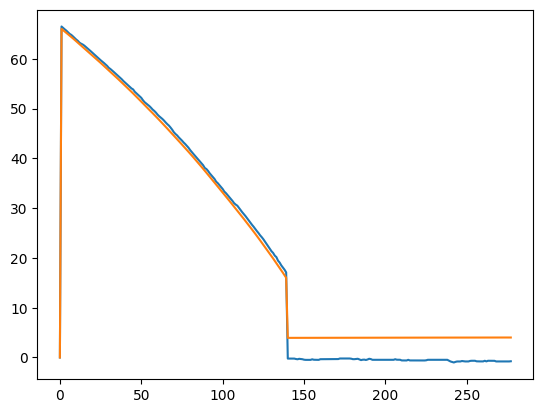

In [143]:
seaborn.lineplot(fastMoves[0])
seaborn.lineplot(fastMoves[1])